In [13]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score  
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import itertools
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.set_printoptions(threshold=np.nan)

#data is veel groter, want alle alcohol
pdata = pd.read_csv("../Data/preprocessed_balance_perperson_nobril_80-20.csv")
# pdata = pdata.drop(["Unnamed: 0"], axis=1)
pdata['Conditie'] = pdata['Conditie'].map({'norm': 0,  'bril': 1})
# pdata = pdata.drop(pdata[pdata.Balance_MeanVelocity_Class.eq(1)].sample(90).index)
pdata.groupby('Balance_MeanVelocity_Class').count()
# pdata['Alcohol'] = pdata['Alcohol'].map({'Sober': 0,  'Light': 1, 'Tipsy': 2, 'Drunk': 3})
# pdata = pdata[pdata.Alcohol == 0]

,Conditie,SubjectID,Height,Weight,Age,BMI,Alcohol,Alcohol_Class,Balance_MLrange,Balance_MLstdev,...,Balance_APrange,Balance_APstdev,Balance_APmeanVelocity,Balance_MeanVelocity,GaitVelocity,MovementVelocity,std_SegmentData,mad_SegmentData,mean_StepLength,Velocity
Balance_MeanVelocity_Class,,,,,,,,,,,,,,,,,,,,,
0,32,32,32,32,32,32,32,32,32,32,...,32,32,32,32,32,32,32,32,32,32
1,122,122,122,122,122,122,122,122,122,122,...,122,122,122,122,122,122,122,122,122,122


In [2]:
#Splits data into training and validation according to specified ratio
def validation_split(data, ratio):
    sidlist = data['SubjectID'].unique()
    gdata = [data[data['SubjectID']==sid] for sid in sidlist]
    np.random.shuffle(gdata)
    N = len(gdata)
    training = gdata[:int(ratio*N)]
    validation = gdata[(int(ratio*N)):]
    return training,validation

# Converts the arrays in a list to one flattend dataframe
def flatten(data, variable_list):
    return pd.DataFrame(np.vstack(data), columns=variable_list)

def get_split_data(originaldata, variable_list, ratio):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Balance_MeanVelocity_Class', 'SubjectID'], axis=1)
    y_train = training['Balance_MeanVelocity_Class']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Balance_MeanVelocity_Class', 'SubjectID'], axis=1)
    y_test = validation['Balance_MeanVelocity_Class']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    return X_train, X_test, y_train, y_test

collist =  ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'mad_SegmentData']
X_train, X_test, y_train, y_test = get_split_data(pdata, collist , 0.7)


X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=int)

X_test = np.array(X_test, dtype=float)
y_test = np.array(y_test, dtype=int)


In [3]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Make an instance of the Model
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(X_train, y_train)

y_pred = logisticRegr.predict(X_test)

Confusion matrix, without normalization
[[5 5]
 [7 3]]


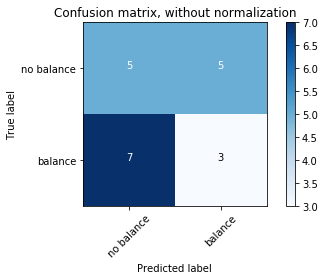

In [4]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['no balance', 'balance'],
                      title='Confusion matrix, without normalization')

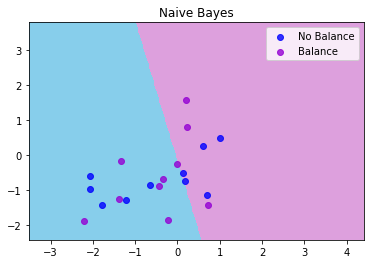

In [5]:
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
cmap_back = ListedColormap(['skyblue', 'plum'])

h = .02  # step size in the mesh
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = logisticRegr.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)


colors = ['blue', 'darkviolet']
for label in np.unique(y_test):
    indices = np.where(y_test == label)
    plt.scatter(X_test[indices, 0], X_test[indices, 1], c=colors[label], alpha=0.8, 
                label=' {}'.format(label))

labels = ['No Balance', 'Balance']
plt.legend(labels)
plt.title('Naive Bayes')
plt.savefig('Naive_Bayes')
plt.show()

In [6]:
def make_decisions(originaldata, variable_list):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Balance_MeanVelocity_Class', 'SubjectID'], axis=1)
    y_train = training['Balance_MeanVelocity_Class']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Balance_MeanVelocity_Class', 'SubjectID'], axis=1)
    y_test = validation['Balance_MeanVelocity_Class']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    
    scaler = StandardScaler()

    # Fit on training set only.
    scaler.fit(X_train)

    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Make an instance of the Model
    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    logisticRegr = LogisticRegression(solver = 'lbfgs')
    logisticRegr.fit(X_train, y_train)

    y_pred = logisticRegr.predict(X_test)

    return accuracy_score(y_test, y_pred) *100



make_decisions(pdata, collist)

60.0

In [7]:
print('mad_SegmentData, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class','mean_StepLength', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, mad_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'Velocity', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'Height']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'Age']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Height']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Age']) for i in range(100)]), 2),'%.')
print('GaitTime, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'Velocity', 'Height']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mad_SegmentData', 'Height']) for i in range(100)]), 2),'%.')
print('mad_SegmentData, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mad_SegmentData', 'Age']) for i in range(100)]), 2),'%.')
print('GaitTime, std_SegmentData, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID','Balance_MeanVelocity_Class', 'Velocity', 'std_SegmentData', 'mean_StepLength']) for i in range(100)]), 2),'%.')




mad_SegmentData, mean_StepLength: 55.55 %.
mean_StepLength, std_SegmentData: 55.9 %.
GaitTime, mean_StepLength, mad_SegmentData: 52.0 %.
std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength: 49.5 %.
GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData: 48.35 %.
GaitTime, mean_StepLength, Height: 54.1 %.
GaitTime, mean_StepLength, Age: 52.05 %.
mean_StepLength, Height: 55.05 %.
mean_StepLength, Age: 56.0 %.
GaitTime, Height: 44.2 %.
std_SegmentData, Height: 38.8 %.
mad_SegmentData, Age: 48.3 %.
GaitTime, std_SegmentData, mean_StepLength: 51.8 %.


In [9]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score  
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import itertools
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.set_printoptions(threshold=np.nan)

pdata = pd.read_csv("../Data/preprocessed_balance_perperson_nobril_80-20.csv")
pdata['Conditie'] = pdata['Conditie'].map({'norm': 0,  'bril': 1})
pdata.groupby('Balance_MeanVelocity_Class').count()

,Conditie,SubjectID,Height,Weight,Age,BMI,Alcohol,Alcohol_Class,Balance_MLrange,Balance_MLstdev,...,Balance_APrange,Balance_APstdev,Balance_APmeanVelocity,Balance_MeanVelocity,GaitVelocity,MovementVelocity,std_SegmentData,mad_SegmentData,mean_StepLength,Velocity
Balance_MeanVelocity_Class,,,,,,,,,,,,,,,,,,,,,
0,32,32,32,32,32,32,32,32,32,32,...,32,32,32,32,32,32,32,32,32,32
1,122,122,122,122,122,122,122,122,122,122,...,122,122,122,122,122,122,122,122,122,122


In [2]:
#Splits data into training and validation according to specified ratio
def validation_split(data, ratio):
    sidlist = data['SubjectID'].unique()
    gdata = [data[data['SubjectID']==sid] for sid in sidlist]
    np.random.shuffle(gdata)
    N = len(gdata)
    training = gdata[:int(ratio*N)]
    validation = gdata[(int(ratio*N)):]
    return training,validation

# Converts the arrays in a list to one flattend dataframe
def flatten(data, variable_list):
    return pd.DataFrame(np.vstack(data), columns=variable_list)

def get_split_data(originaldata, variable_list, ratio):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Balance_MeanVelocity_Class', 'SubjectID'], axis=1)
    y_train = training['Balance_MeanVelocity_Class']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Balance_MeanVelocity_Class', 'SubjectID'], axis=1)
    y_test = validation['Balance_MeanVelocity_Class']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    return X_train, X_test, y_train, y_test

collist =  ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'mad_SegmentData']
X_train, X_test, y_train, y_test = get_split_data(pdata, collist , 0.7)


X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=int)

X_test = np.array(X_test, dtype=float)
y_test = np.array(y_test, dtype=int)


In [3]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Make an instance of the Model
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(X_train, y_train)

y_pred = logisticRegr.predict(X_test)

Confusion matrix, without normalization
[[5 5]
 [7 3]]


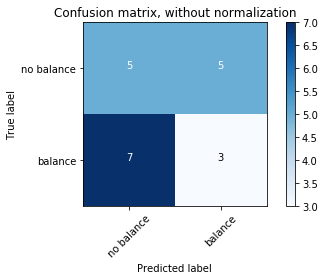

In [4]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['no balance', 'balance'],
                      title='Confusion matrix, without normalization')

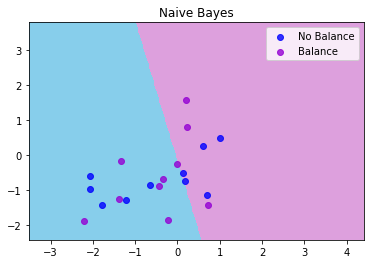

In [5]:
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
cmap_back = ListedColormap(['skyblue', 'plum'])

h = .02  # step size in the mesh
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = logisticRegr.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)


colors = ['blue', 'darkviolet']
for label in np.unique(y_test):
    indices = np.where(y_test == label)
    plt.scatter(X_test[indices, 0], X_test[indices, 1], c=colors[label], alpha=0.8, 
                label=' {}'.format(label))

labels = ['No Balance', 'Balance']
plt.legend(labels)
plt.title('Naive Bayes')
plt.savefig('Naive_Bayes')
plt.show()

In [6]:
def make_decisions(originaldata, variable_list):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Balance_MeanVelocity_Class', 'SubjectID'], axis=1)
    y_train = training['Balance_MeanVelocity_Class']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Balance_MeanVelocity_Class', 'SubjectID'], axis=1)
    y_test = validation['Balance_MeanVelocity_Class']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    
    scaler = StandardScaler()

    # Fit on training set only.
    scaler.fit(X_train)

    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Make an instance of the Model
    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    logisticRegr = LogisticRegression(solver = 'lbfgs')
    logisticRegr.fit(X_train, y_train)

    y_pred = logisticRegr.predict(X_test)

    return accuracy_score(y_test, y_pred) *100



make_decisions(pdata, collist)

60.0

In [ ]:
print('mad_SegmentData, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class','mean_StepLength', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, mad_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'Velocity', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'Height']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Velocity', 'Age']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Height']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mean_StepLength', 'Age']) for i in range(100)]), 2),'%.')
print('GaitTime, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'Velocity', 'Height']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mad_SegmentData', 'Height']) for i in range(100)]), 2),'%.')
print('mad_SegmentData, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Balance_MeanVelocity_Class', 'mad_SegmentData', 'Age']) for i in range(100)]), 2),'%.')
print('GaitTime, std_SegmentData, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID','Balance_MeanVelocity_Class', 'Velocity', 'std_SegmentData', 'mean_StepLength']) for i in range(100)]), 2),'%.')




mad_SegmentData, mean_StepLength: 55.55 %.
mean_StepLength, std_SegmentData: 55.9 %.
GaitTime, mean_StepLength, mad_SegmentData: 52.0 %.
std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength: 49.5 %.
